In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
palette = 'colorblind'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)

import theano.tensor as tt
import theano.tensor.slinalg as slinalg

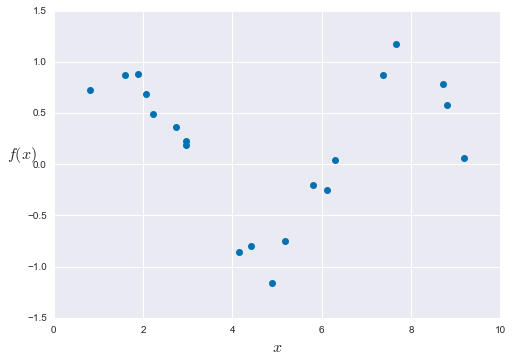

In [2]:
np.random.seed(5)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('GP_inputs.png');

In [3]:
def kernel(a, b, kernel_name='squared_exponential'):

    def squared_exponential(a, b):
        """Squared exponential kernel 
    
        """
        D = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
        return eta * np.exp(- rho * D)

    def periodic(a, b):
        """periodic kernel
    
        """
        a = np.sin(a)
        b = np.sin(b)
        D = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
        return eta * np.exp(- rho * D)
   
    if kernel_name == 'squared_exponential':
        return squared_exponential(a, b)
    elif kernel_name == 'periodic':
        return periodic(a, b)

In [4]:
N = len(x)
# Sample points we should have at least 2d data
X = np.atleast_2d(x).T
# test points
Xtest = np.linspace(0, 10, 100).reshape(-1,1)

In [5]:
with pm.Model() as GP:

    mu = np.zeros(len(x))
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
   
    kernel_name = 'squared_exponential'
    K = kernel(X, X, kernel_name)
    cov = K + sigma * tt.eye(N)

    obs = pm.MvNormal('obs', mu, cov=cov, observed=y)
    

    # compute the mean at our test points.    
    L = slinalg.cholesky(cov)
    alpha = slinalg.solve(L.T, slinalg.solve(L, y))
    Ko = kernel(X, Xtest, kernel_name)
    mu_post = pm.Deterministic('mu_post', tt.dot(Ko.T, alpha))
    
    # compute the standard deviation at our test points.
    Koo = kernel(Xtest, Xtest, kernel_name)
    v = slinalg.solve(L, Ko)
    sigma_post = pm.Deterministic('sigma_post', tt.diag((Koo - tt.dot(v.T, v))**0.5))
    
    start = pm.find_MAP()
    trace = pm.sample(1000, step=pm.Metropolis(), start=start, random_seed=1)

100%|██████████| 1000/1000 [00:07<00:00, 128.20it/s]

Optimization terminated successfully.
         Current function value: 14.165786
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


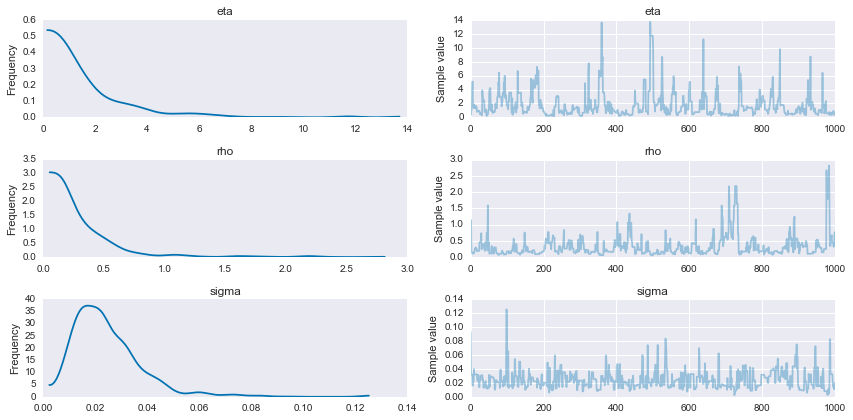

In [6]:
varnames = ['eta', 'rho', 'sigma']
pm.traceplot(trace, varnames);

In [7]:
pm.df_summary(trace, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
eta,1.772632,1.885271,0.142476,0.159785,5.437536
rho,0.325971,0.338045,0.025670,0.054355,0.866422
sigma,0.024502,0.013440,0.000767,0.006250,0.048244


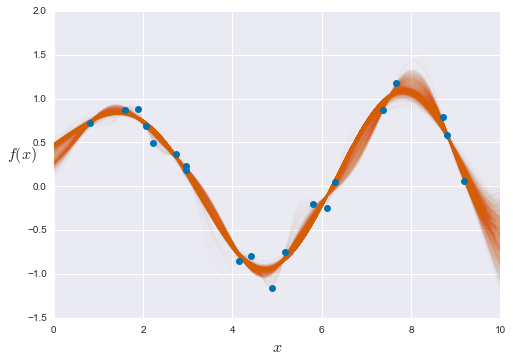

In [8]:
m = trace['mu_post']

plt.plot(Xtest, m.T, 'r', alpha=0.01)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);
plt.savefig('GP_posterior_means_{}.png'.format(kernel_name))

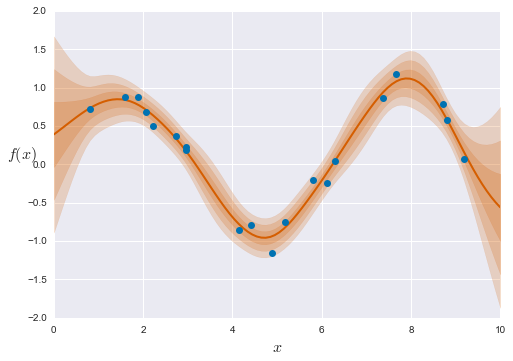

In [9]:
m = trace['mu_post'].mean(0)
s = trace['sigma_post'].mean(0)

for i in range(1, 4):
    plt.fill_between(Xtest.flat, m - i * s, m + i * s, color="r", alpha=0.2)


plt.plot(Xtest, m, 'r', lw=2)
plt.plot(Xtest, m.T, 'r', alpha=0.01)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);
plt.savefig('GP_posteriors_sd_{}.png'.format(kernel_name))

In [10]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc2
NumPy 1.11.2
Matplotlib 1.5.3
Seaborn 0.7.1

